In [1]:
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [2]:
# QM9 dataset contains 133855 small organic molecules labeled with several geometric, energetic, electronic, and thermodynamic properties
dataset = QM9('../data/')

Extracting ..\data\raw\qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


In [3]:
len(dataset)

130831

In [4]:
data = dataset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [5]:
data.z  # could access attributes directly

tensor([6, 1, 1, 1, 1])

In [6]:
# add nodes into data
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [7]:
device = 'cuda'
data.to(device)
data.new_attribute.is_cuda

True

The bond types of molecules are important; that is, which atoms are connected via a certain bond type, for example, single or double bonds, matters. Hence, we want to use a graph convolution that can utilize edge features.
This convolution in the NNConv layer takes the following form:
$$
\mathbf{X}_i^{(t)} = \mathbf{WX}_i^{(t-1)} + \sum_{j\in N(i)}\mathbf{X}_j^{(t-1)}\cdot h_\Theta(e_{i,j})
$$
Here, $h$ is a neural network parameterized by a set of weights $\Theta$, and $mathbf{W}$ is a weight matrix for the node labels. This graph convolution is very similar to the one we implemented from scratch in the demo_GNN.py:
$$
mathbf{X}_i^{(t)} = \mathbf{W}_1\mathbf{X}_i^{(t-1)} + \sum_{j \in N(i)} \mathbf{X}_j^{(t-1)}\mathbf{W}_2
$$
Only difference between them is that the W2 equivalent, the neural network h, is parametrized based on the edge lables, which allows the weights to vary for different edge labels.

In [8]:
class ExampleNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features * 32)
        )
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32 * 16)
        )
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr = data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [9]:
from torch.utils.data import random_split
train_set, valid_set, test_set = random_split(dataset, [110000, 10831, 10000])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [10]:
node_feats, edge_feats = 11, 4
net = ExampleNet(node_feats, edge_feats)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1  # index position of the polarizability label
net.to('cuda')

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()  # step is used to tell the optimizer to update x
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in valid_loader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    print(f'epochs: {total_epochs} | epoch avg loss: {train_avg_loss:.2f} | validation avg loss: {val_avg_loss:.2f}')

epochs: 0 | epoch avg loss: 0.46 | validation avg loss: 0.10
epochs: 1 | epoch avg loss: 0.13 | validation avg loss: 0.67
epochs: 2 | epoch avg loss: 0.11 | validation avg loss: 0.11
epochs: 3 | epoch avg loss: 0.11 | validation avg loss: 0.09


In [12]:
net.eval()
predictions = []
real = []
for batch in test_loader:
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

Text(0, 0.5, 'Predicted isotropic polarizability')

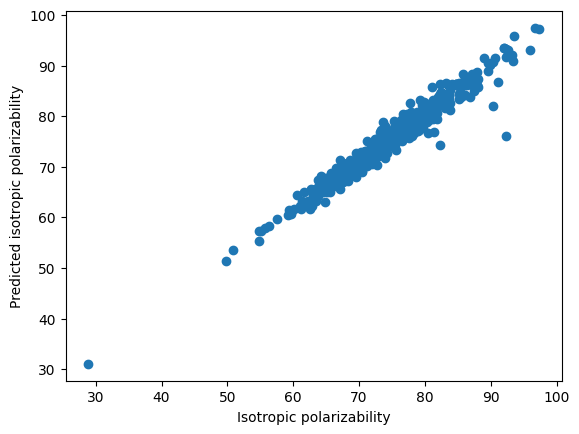

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(real[:500], predictions[:500])
plt.xlabel('Isotropic polarizability')
plt.ylabel('Predicted isotropic polarizability')